# Volume scan from  multiple sweeps using xradar
This example show how create a volume scan using multiple sweep files from AWS. The volume scan structure is based on [tree-like](https://xarray-datatree.readthedocs.io/en/latest/generated/datatree.DataTree.html) hierarchical collection of xarray objects 

## Imports

In [1]:
import fsspec
import xarray as xr
import xradar as xd
import boto3
import botocore
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from pandas import to_datetime
from botocore.client import Config
from datetime import datetime
from matplotlib import pyplot
from datatree import DataTree, open_datatree

warnings.simplefilter("ignore")
# pyplot.style.use('dark_background')

## Access radar data from Colombian radar network on AWS
Access data from IDEAM bucket on AWS. Detailed information can be found [here](https://openradar-docs--102.org.readthedocs.build/projects/xradar/en/102/notebooks/Read-plot-Sigmet-data-from-AWS.html) 

In [2]:
def create_query(date, radar_site):
    """
    Creates a string for quering the IDEAM radar files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param radar_site: radar site e.g. Guaviare
    :return: string with a IDEAM radar bucket format
    """
    if (date.hour != 0) and (date.hour != 0):
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d%H}'
    elif (date.hour != 0) and (date.hour == 0):
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'
    else:
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'

In [3]:
date_query = datetime(2023, 4, 7, 3)
radar_name = "Barrancabermeja" 
query = create_query(date=date_query, radar_site=radar_name)
str_bucket = 's3://s3-radaresideam/'
fs = fsspec.filesystem("s3", anon=True)

In [4]:
query

'l2_data/2023/04/07/Barrancabermeja/BAR23040703'

In [5]:
radar_files = sorted(fs.glob(f"{str_bucket}{query}*"))
radar_files[:4]

['s3-radaresideam/l2_data/2023/04/07/Barrancabermeja/BAR230407030004.RAW0LZ9',
 's3-radaresideam/l2_data/2023/04/07/Barrancabermeja/BAR230407030107.RAW0LZC',
 's3-radaresideam/l2_data/2023/04/07/Barrancabermeja/BAR230407030238.RAW0LZE',
 's3-radaresideam/l2_data/2023/04/07/Barrancabermeja/BAR230407030315.RAW0LZH']

## Let's check elevation at each files using `xradar.datatree` module

IDEAM radar network operates with a volume scan every five minutes. Each volume scan has four different tasks 
* *SURVP* "super resolution" sweep at the lowest elevation angle, usually 0.5 deg,  with 720 degrees in azimuth (every 0.5 deg)
* *PRECA* task with 1.5, 2.4, 3.0, and 5.0 elevation angles and shorter range than *SURVP*
* *PRECB* task with 6.4 and 8.0 elevation angles and shorter range than previous task
* *PRECC* task with 10.0, 12.5, and 15.0 with shorter range than previous task as well

In [6]:
# List of first four task files
task_files = [fsspec.open_local(f'simplecache::s3://{i}', s3={'anon': True}, filecache={'cache_storage': '.'}) 
             for i in radar_files[:4]]

In [7]:
for i in task_files:
    ds = xd.io.open_iris_datatree(i)
    sweeps = list(ds.children.keys())
    print(f"task sweeps: {sweeps}")
    for i in sweeps:
        print(i)
        print(f"range : {ds[i].range.values[-1] / 1e3:.1f} [km]")
        print(f"elevation {ds[i].sweep_fixed_angle.values: .1f} [deg]")
    print("----------------------------------------------------------------")


task sweeps: ['sweep_0']
sweep_0
range : 298.9 [km]
elevation  1.3 [deg]
----------------------------------------------------------------
task sweeps: ['sweep_0', 'sweep_1', 'sweep_2', 'sweep_3']
sweep_0
range : 224.8 [km]
elevation  1.5 [deg]
sweep_1
range : 224.8 [km]
elevation  2.4 [deg]
sweep_2
range : 224.8 [km]
elevation  3.1 [deg]
sweep_3
range : 224.8 [km]
elevation  5.1 [deg]
----------------------------------------------------------------
task sweeps: ['sweep_0', 'sweep_1']
sweep_0
range : 175.0 [km]
elevation  6.4 [deg]
sweep_1
range : 175.0 [km]
elevation  8.0 [deg]
----------------------------------------------------------------
task sweeps: ['sweep_0', 'sweep_1', 'sweep_2']
sweep_0
range : 99.0 [km]
elevation  10.0 [deg]
sweep_1
range : 99.0 [km]
elevation  12.5 [deg]
sweep_2
range : 99.0 [km]
elevation  15.0 [deg]
----------------------------------------------------------------


## Create a  sigle volume scan
Let's use the first four files, tasks *SURVP*, *PRECA*, *PRECB*, *PRECC*, to create a single volume scan 

In [8]:
# list of xradar datatrees
ls_dt = [xd.io.open_iris_datatree(i).xradar.georeference() for i in task_files]

Now that we have each task as a Datatree we can create our Datatree object with all task as children.

In [9]:
vcp_dt = DataTree(name='root', children=dict(SURVP=ls_dt[0], PRECA=ls_dt[1], PRECB=ls_dt[2], PRECC=ls_dt[3]))

In [10]:
vcp_dt.groups

('/',
 '/SURVP',
 '/SURVP/sweep_0',
 '/PRECA',
 '/PRECA/sweep_0',
 '/PRECA/sweep_1',
 '/PRECA/sweep_2',
 '/PRECA/sweep_3',
 '/PRECB',
 '/PRECB/sweep_0',
 '/PRECB/sweep_1',
 '/PRECC',
 '/PRECC/sweep_0',
 '/PRECC/sweep_1',
 '/PRECC/sweep_2')

In [11]:
print(f"Size of data in tree = {vcp_dt.nbytes / 1e6 :.2f} MB")

Size of data in tree = 192.58 MB


## Creating a PPI plot from the Datatree object

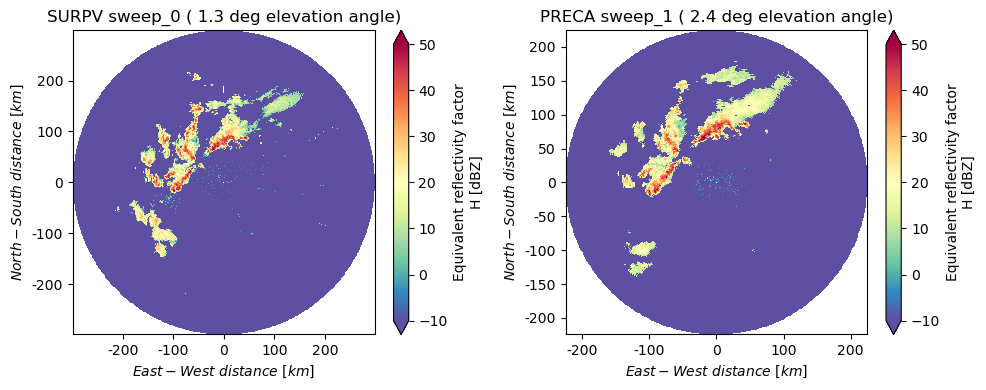

In [12]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
vcp_dt.SURVP.sweep_0.DBZH.plot(x='x', y='y', cmap='Spectral_r', vmin=-10, vmax=50, ax=ax)
ax.set_title(f"SURPV sweep_0 ({vcp_dt.SURVP.sweep_0.sweep_fixed_angle.values: .1f} deg elevation angle)")
m2km = lambda x, _: f"{x/1000:g}"
ax.xaxis.set_major_formatter(m2km)
ax.yaxis.set_major_formatter(m2km)

vcp_dt.PRECA.sweep_1.DBZH.plot(x='x', y='y', cmap='Spectral_r', vmin=-10, vmax=50, ax=ax1)
ax1.set_title(f"PRECA sweep_1 ({vcp_dt.PRECA.sweep_1.sweep_fixed_angle.values: .1f} deg elevation angle)")
m2km = lambda x, _: f"{x/1000:g}"
ax1.xaxis.set_major_formatter(m2km)
ax1.yaxis.set_major_formatter(m2km)

ax.set_ylabel('$North - South \ distance \ [km]$')
ax.set_xlabel('$East - West \ distance \ [km]$')
ax1.set_ylabel('$North - South \ distance \ [km]$')
ax1.set_xlabel('$East - West \ distance \ [km]$')
fig.tight_layout()

## Multiple volume scans into one `datatree` object

Similarly, we can create a tree-like hierarchical object with multiple volume scans

In [13]:
def data_accessor(file):
    """
    Open AWS S3 file(s) which can be resolved to local by dile caching
    """
    return fsspec.open_local(f'simplecache::s3://{file}', s3={'anon': True}, filecache={'cache_storage': '.'})

def create_vcp(ls_dt):
    """
    Creates a tree-like object for each volume scan
    """
    return DataTree(name='root', children=dict(SURVP=ls_dt[0], PRECA=ls_dt[1], PRECB=ls_dt[2], PRECC=ls_dt[3]))

def mult_vcp(radar_files):
    """
    Creates a tree-like object for multiple volume scan every 4th file in the bucket
    """
    ls_files = [radar_files[i:i+4] for i in range(len(radar_files)) if i % 4 == 0]
    ls_sigmet = [[xd.io.open_iris_datatree(data_accessor(i)).xradar.georeference() for i in j] for j in ls_files]    
    ls_dt = [create_vcp(i) for i in ls_sigmet] 
    return DataTree.from_dict({f'vpc_{idx}': i for idx, i in enumerate(ls_dt)})

In [14]:
# let's test it using the first 16 files found in the bucket
dt_vcp = mult_vcp(radar_files[:16])

In [15]:
list(dt_vcp.keys())

['vpc_0', 'vpc_1', 'vpc_2', 'vpc_3']

In [16]:
print(f"Size of data in tree = {dt_vcp.nbytes / 1e9 :.2f} GB")

Size of data in tree = 0.77 GB


### Let's create an animation using the lowest elevation angle

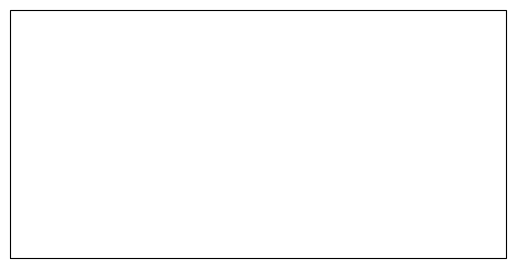

In [17]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

def animate(vcp, task="SURVP", sweep="sweep_0"):
    proj_crs = xd.georeference.get_crs(vcp[task])
    cart_crs = ccrs.Projection(proj_crs)
    sc = vcp[task][sweep].DBZH.where(vcp[task][sweep].DBZH > -10).plot.pcolormesh(x="x", y="y", 
                                                                             vmin=-10, vmax=50, 
                                                                             cmap="Spectral_r", 
                                                                             edgecolors="face", 
                                                                             transform=cart_crs,
                                                                             ax=ax)

    title = f"{task} - {sweep} ({vcp_dt[task][sweep].sweep_fixed_angle.values: .1f} deg)"
    ax.set_title(title)
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=1,
        color="gray",
        alpha=0.3,
        linestyle="--",
    )
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    gl.top_labels = False
    gl.right_labels = False
    ax.coastlines()
    return sc

In [ ]:
artist = [animate(dt_vcp[i]) for i in dt_vcp]

## Storaging data in Analysis-ready cloud format

In [ ]:
zarr_store = './multiple_vcp_test.zarr'
_ = dt_vcp.to_zarr(zarr_store)

In [ ]:
! ls multiple_vcp_test.zarr

## Reading zarr files using `datatree.open_datatree` module

In [ ]:
ds = open_datatree(zarr_store, engine="zarr")

In [ ]:
ds